In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math 
import mmh3 
sns.set()

### Using scenario 3 (Dataset 44 on the CTU website)     
Please note that these files have been processed using the "Data_processing" notebook, which takes in the original file from the website, preprocesses it, and saves it again in csv file.

In [2]:
DATA_PATH_ORIG = r'../data/scenario_3.csv'

In [3]:
df = pd.read_csv(DATA_PATH_ORIG, parse_dates=['start_date'])
df.head()

,start_date,duration,protocol,src_addr,dst_addr,flags,tos,packets,bytes,flows,label,src_port,dst_port
0,2011-08-12 15:24:01.105,4.677,TCP,74.125.108.243,147.32.86.187,PA_,0,452,682688,1,Background,80,55707
1,2011-08-12 15:24:01.105,3.110,TCP,147.32.84.164,83.208.193.123,PA_,0,5,506,1,LEGITIMATE,22,15173
2,2011-08-12 15:24:01.105,4.678,TCP,147.32.86.187,74.125.108.243,A_,0,106,6510,1,LEGITIMATE,55707,80
3,2011-08-12 15:24:01.106,4.989,TCP,217.168.211.184,147.32.84.14,PA_,0,1393,95812,1,Background,3953,22
4,2011-08-12 15:24:01.113,4.988,UDP,173.9.132.155,147.32.84.59,INT,0,811,680898,1,Background,54369,15046


In [4]:
df.shape

(15202060, 13)

In [5]:
df['label'].unique()

array(['Background', 'LEGITIMATE', 'Botnet'], dtype=object)

As we discussed in Mattermost, we are interested in the connections between the **infected** host (it is only one in this dataset) and the other IPs 

### From website: infected host --> 147.32.84.165

In [6]:
host_ip = "147.32.84.165"

Let's keep all the other IPs the host connects with

In [7]:
connections = df[(df['src_addr'] == host_ip) | (df['dst_addr'] == host_ip)][['src_addr', 'dst_addr']]

other_ips = connections.apply(lambda row: row['dst_addr'] if row['src_addr'] == host_ip else row['src_addr'], axis=1)
print(f"{other_ips.size} connections with the host found.")

75891 connections with the host found.


Just a sanity check to assert that we do not have our host_ip somewhere in the list of IPs

In [43]:
print(len([ip for ip in other_ips if ip != host_ip]))
print(len(other_ips))

75891
75891


Let's compute the real frequencies of other IPs, and let's retain the top 10, as requested

In [44]:
benchmark_counts = other_ips.value_counts().sort_values(ascending=False)
benchmark_counts[:10]

178.77.71.27      12424
38.229.70.20       3828
147.32.96.45       1218
195.113.235.89      723
109.74.55.27        397
64.31.13.148        282
208.86.166.68       282
210.139.61.102      181
208.100.127.34       90
210.139.61.70        72
dtype: int64

# Count Min Sketch

Resource: https://olivif.github.io/2017/count-min-sketch/

Resource for independent hash functions: https://www.geeksforgeeks.org/bloom-filters-introduction-and-python-implementation/

Let's starts by implementing the function that computes the **INDEPENDENT** hashings.

In [9]:
def get_hash_indexes(item, hash_count, bit_array_size):
    digests = [] 
    for i in range(hash_count):  
        # we use the index as a seed for the hashing function
        digest = mmh3.hash(item,i) % bit_array_size 
        digests.append(digest) 
  
    return digests

Let's implement the function that implements the count-min sketch algorithm:    
- given an IP address, we hash it with the independent hashing functions defined above
- we increment the count of all the locations identified by the result of the hashings

In [10]:
def get_count_min_sketch_buckets(original, height, width):
    buckets = np.zeros((height, width))
    unique_ips = set()

    for ip in original:
        digests = get_hash_indexes(ip, height, width)
        unique_ips.add(ip)

        for id_height, id_width in enumerate(digests):
            buckets[id_height, id_width] += 1
            
    return unique_ips, buckets

Let's implement the function that retrieves the count of a certain IP address, after the stream has been processed:     
- given an IP address, we hash it with the independent hashing functions
- we obtain the locations of the different buckets for such IP address
- we take the minimum count among the identified locations, as it is the most reliable

In [11]:
def get_frequencies(unique_ips, buckets, height, width):
    frequencies = []
    for ip in unique_ips:
        hash_ip = get_hash_indexes(ip, height, width)

        bucket_values = []

        for id_height, id_width in enumerate(hash_ip):
            bucket_values.append( buckets[id_height, id_width])

        frequencies.append(np.min(bucket_values)/len(other_ips))

    freq_series = pd.Series(frequencies, index = unique_ips)
    freq_series = freq_series.sort_values(ascending=False)

    return freq_series

As we did for reservoir sampling, we evaluate the algorithm using recall at the top 10 most frequent IP addresses the monitored host connects with

In [63]:
def compute_count_min_sketch_error(original, sampled_freq, n_of_ips):
    n_ips_original = original.size
    original = original.value_counts().sort_values(ascending=False)
    
    top_n_to_find = original[:n_of_ips].index
    top_n_found = sampled_freq[:n_of_ips].index
        
    errors = []
    for ip in top_n_found:
        real_freq = original[ip]/n_ips_original
        estimated_freq = sampled_freq[ip]
        errors.append(abs(real_freq-estimated_freq))
    mean_error = np.mean(errors)
        
    retrieved = set.intersection(set(top_n_to_find), set(top_n_found))
    return len(retrieved), mean_error

### As requested in the assignment, we perform count-min sketch with different heights and widths    
Intuitively, the wider the matrix, the more buckets we have, and therefore we are less likely to increase the wrong bucket.  Also, the more hashing functions we use (the heigth), the more likely we are to avoid collisions in some of the rows of the matrix, thus retrieving the correct count when we select the minimum count.

In [71]:
height = np.arange(2, 15, 1)
width =  np.arange(50, 1000, 25)

recalls = np.zeros((len(height), len(width)))
mean_errors = np.zeros((len(height), len(width)))

for i, h in enumerate(height):
    for j, w in enumerate(width):
        
        unique_ips, buckets = get_count_min_sketch_buckets(other_ips, h, w)
        freq = get_frequencies(unique_ips, buckets, h, w)
        recall, mean_error = compute_count_min_sketch_error(other_ips, freq, 10)
        
        recalls[i,j] = recall
        mean_errors[i,j] = mean_error

Let's visualize the results on a heatmap (heatmaps are cool :D)

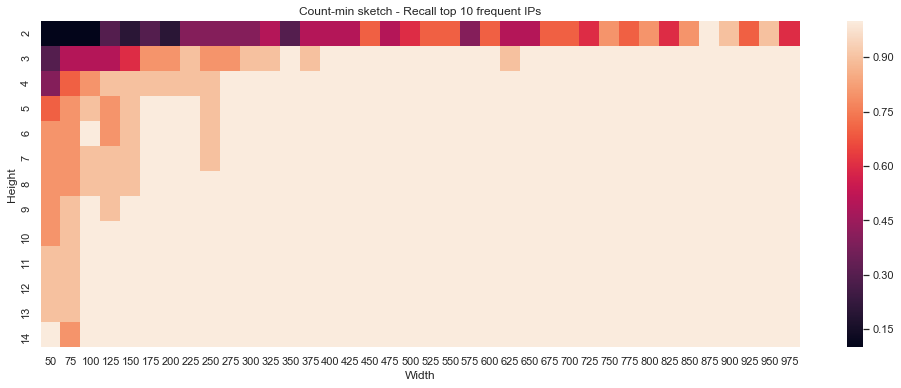

In [76]:
results_df =pd.DataFrame(recalls/10, index = height, columns=width)

plt.figure(figsize=(17, 6))
plt.title("Count-min sketch - Recall top 10 frequent IPs")
sns.heatmap(results_df)
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()

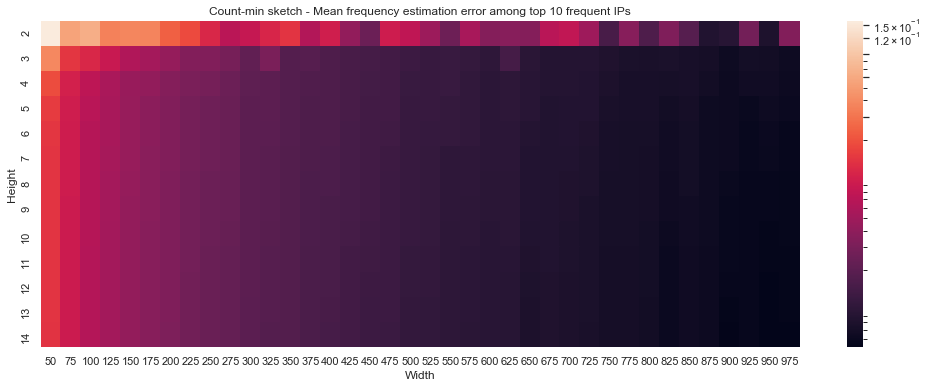

In [75]:
from matplotlib.colors import LogNorm

results_df =pd.DataFrame(mean_errors, index = height, columns=width)

plt.figure(figsize=(17, 6))
plt.title("Count-min sketch - Mean frequency estimation error among top 10 frequent IPs")
sns.heatmap(results_df, norm=LogNorm(vmin=mean_errors.min(), vmax=mean_errors.max()))
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()

Let's look at the frequencies when we use width = 150 and height = 9

In [37]:
w = 150
h = 9
unique_ips, buckets = get_count_min_sketch_buckets(other_ips, h, w)

In [42]:
get_frequencies(unique_ips, buckets, h, w)[:10]

178.77.71.27      0.168149
38.229.70.20      0.054552
147.32.96.45      0.019936
195.113.235.89    0.014099
109.74.55.27      0.010001
64.31.13.148      0.008499
208.86.166.68     0.007498
210.139.61.102    0.006747
208.100.127.34    0.005640
210.139.61.70     0.005244
dtype: float64

In [45]:
real_result = other_ips.value_counts().sort_values(ascending=False)
real_result = real_result / other_ips.shape[0]

real_result[:10]

178.77.71.27      0.163708
38.229.70.20      0.050441
147.32.96.45      0.016049
195.113.235.89    0.009527
109.74.55.27      0.005231
64.31.13.148      0.003716
208.86.166.68     0.003716
210.139.61.102    0.002385
208.100.127.34    0.001186
210.139.61.70     0.000949
dtype: float64

But how much did we need to store to achieve this result?
- the list of uniques ips, as we need to re-hash them again after the stream is done, to retrieve the frequencies (strings)
- the matrix with width 150 and height 9 (integers)

In [49]:
print(f"Number of strings saved: {len(unique_ips)}")
print(f"Number of integers saved: {h * w}")

Number of strings saved: 27935
Number of integers saved: 1350


For reservoir, we get to 10 successfully retrieved IPs around 10000 reservoir size. However, as we can observe in the case of Count Min Sketching, we can achieve this with lower size. We get steady around height of 5 and width of 300 (so total size 5 * 300 = 1500) as we can observe in the heatmap above. 

However, considering that for Count Min Sketch we also need to store the unique ips for retrieving the minimum bucket size, overall we do need to store more items in memory than in the case of reservoir sampling.

Accuracy wise, both methods are accurate given high enough values for the parameters (i.e. reservoir size and height and width for the 'buckets' matrix for Count Min Sketch). 